---
# <div align="center"><font color='black'> COSC 2669 | Case Studies in Data Science  </font></div>
## <div align="center"> <font color='black'> WIL Project - HELOC explainable models </font></div>
### <div align="center"> <font color='black'> Group 30, Semester 2 2023</font></div>
---

### Introduction

In this notebook for developing and training an explainable machine learning model, aiming to create accurate predictions on the eligibility and consequential amount of a HELOC (Home Equity Line of Credit) loan for a particular borrower, whilst providing insights as to why a particular prediction was made through contributing factors and values through novel applications.

The model will be preliminarily developed and tested, before undergoing further refinement through methods such as hyperparameter tuning on a validation set and/or something like regularisation for a decision-tree based model in order to be able to produce satisfactory results regarding the prediction quality. Then the chosen explainable algorithms will be applied to the model: LIME (https://medium.com/analytics-vidhya/shap-shapley-additive-explanations-and-lime-local-interpretable-model-agnostic-explanations-8c0aa33e91f#:~:text=LIME%20and%20SHAP%20are%20two,model%20locally%20around%20each%20prediction.) which will be only tested within this notebook as it's proper implementation will occur on a .py file that will perform the real predictions on unseen data. The finalised and trained model will then be exported in order to be loaded into the before-mentioned .py file where it will undergo the next steps of development.


The data set from the FICO competition: https://community.fico.com/s/explainable-machine-learning-challenge?tabset-158d9=3, entails applicant information from their credit report, whose attributes should determine whether the borrower is likely capable to repay the loan within two years or not in terms of good or poor risk assessment. 

### Importing Libraries

In [3]:
!pip install lime

  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=890f67d6fb652ea1e1f2d71a9c0578f502a52ce5fcb0becd203df59b34698f76
  Stored in directory: c:\users\lxcic\appdata\local\pip\cache\wheels\ed\d7\c9\5a0130d06d6310bc6cbe55220e6e72dcb8c4eff9a478717066
Successfully built lime


In [128]:
# base imports for data and plots
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# imports for processing // tuning
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler, PowerTransformer

# imports for machine learning methods
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

# imports for evaluation
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix

# imports for LIME (explainable models)
import lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline

### Loading Data

In [2]:
HELOC_DF = pd.read_csv('./heloc_dataset_v1.csv', delimiter=',')

HELOC_DF.head()

,RiskPerformance,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,...,PercentInstallTrades,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance
0,Bad,55,144,4,84,20,3,0,83,2,...,43,0,0,0,33,-8,8,1,1,69
1,Bad,61,58,15,41,2,4,4,100,-7,...,67,0,0,0,0,-8,0,-8,-8,0
2,Bad,67,66,5,24,9,0,0,100,-7,...,44,0,4,4,53,66,4,2,1,86
3,Bad,66,169,1,73,28,1,1,93,76,...,57,0,5,4,72,83,6,4,3,91
4,Bad,81,333,27,132,12,0,0,100,-7,...,25,0,1,1,51,89,3,1,0,80


In [159]:
HELOC_DF.shape

(10459, 24)

In [160]:
# remove entries which do not have a value under external disk estimate
# -9 No Bureau Record or No Investigation
# -8 and -7 are also special values but are not as severe of conditions
HELOC_DF = HELOC_DF[HELOC_DF['ExternalRiskEstimate']!=-9]

In [161]:
HELOC_DF.shape

(9861, 24)

### Splitting

### SAMPLING DISCUSSION BENEFITS AND METHODS

After extensively analysing the dataset to gain a sound comprehension of the relationships between the various attributes and the target variable of risk assessment, The next step is to split the **HELOC** data set into three components: a training set, a validation set and a testing set being of a proportion:
**(60 / 20 / 20)** respectively to try and provide a most appropriate allocation of available data where necessary.

In [162]:
HX, HY = HELOC_DF.drop('RiskPerformance', axis = 1), HELOC_DF['RiskPerformance']
# separating the target label identifying fraudulent transactions from the other attributes


H_train_X, temp_X, H_train_Y, temp_Y = train_test_split(HX, HY, test_size=0.33, random_state = 30)
# as train_test_split can only provide two outputs, we can split the initial dataset into 0.6 and 0.4
# then perform a second split to divide the 0.4 subset into both the validation and test set

H_val_X, H_test_X, H_val_Y, H_test_Y = train_test_split(temp_X, temp_Y, test_size=0.5, random_state = 30)
# random_state allows a seed to be set to determine the splits in the dataset so it is able to be reproduced


print("Number of instances in the original dataset is {}. After spliting Train has {} instances,\n"
      "Val has {} instances and Test has {} instances."
      .format(HELOC_DF.shape[0], H_train_X.shape[0], H_val_X.shape[0], H_test_X.shape[0]))

Nunber of instances in the original dataset is 9861. After spliting Train has 6606 instances,
Val has 1627 instances and Test has 1628 instances.


comparing the distributions between randomly sampled sets shows fairly even distributions across the features to demonstrate with enough certainty there bias will not be an issue

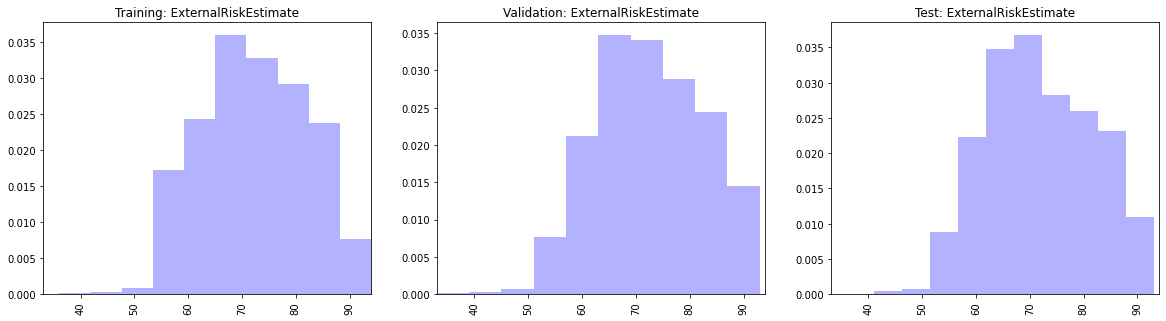

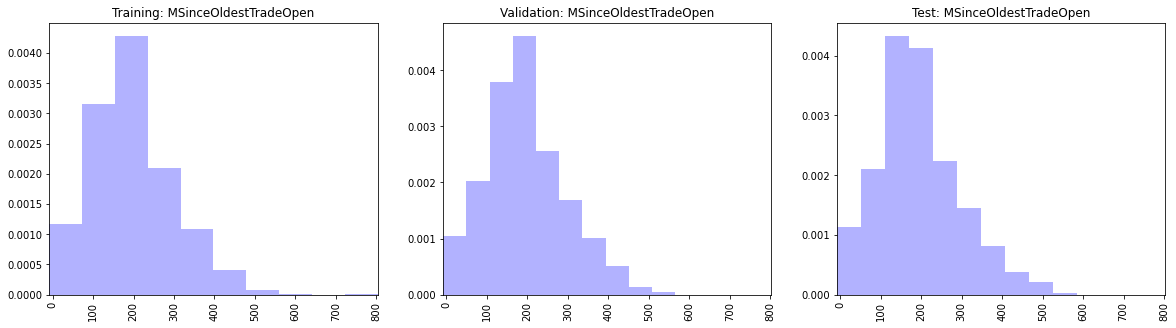

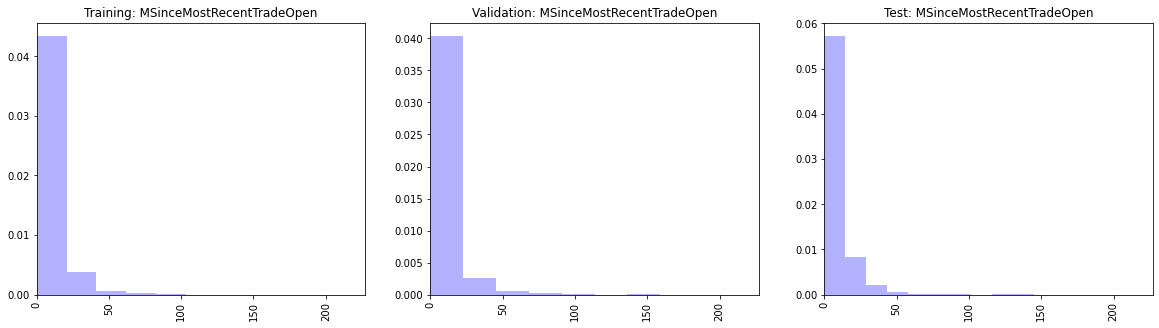

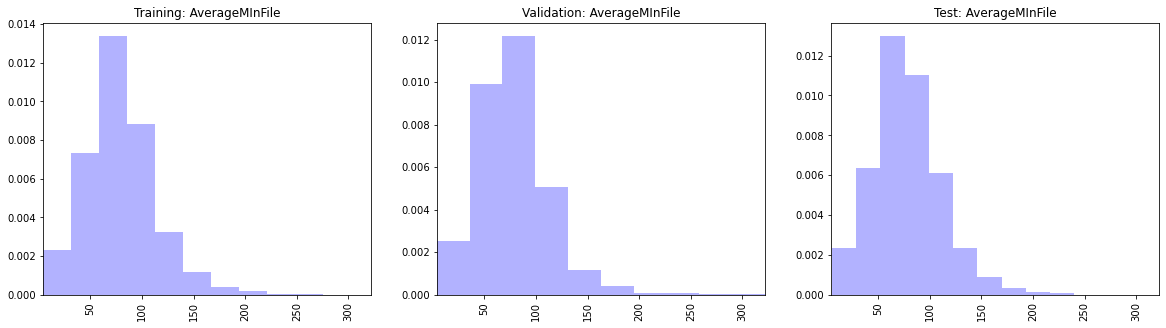

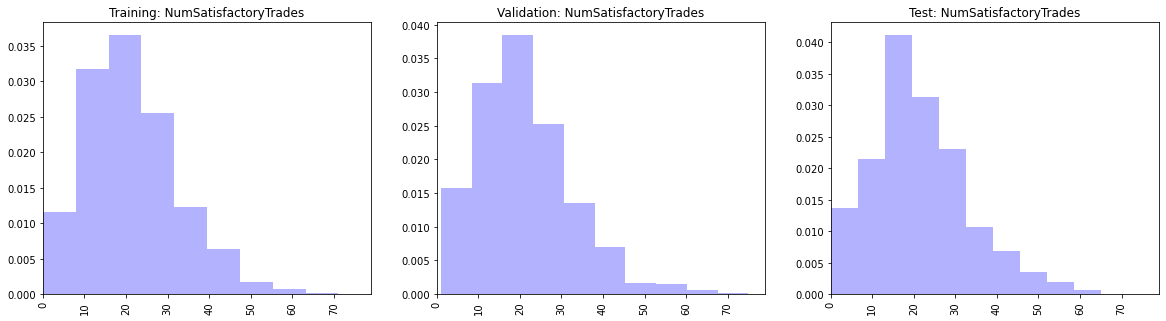

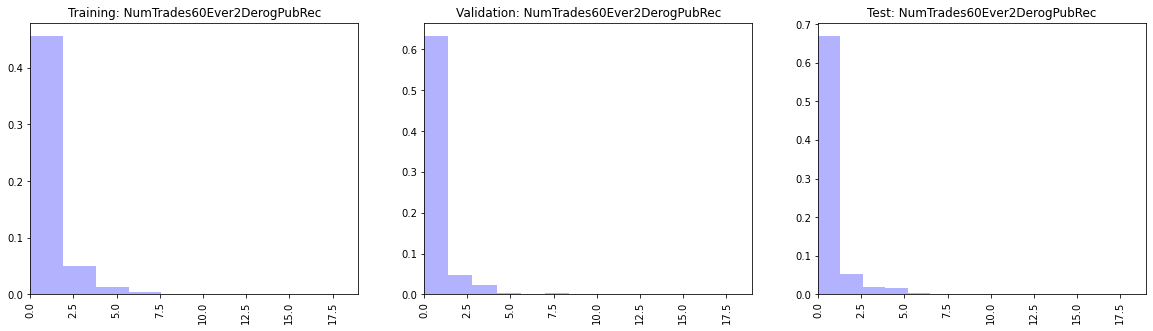

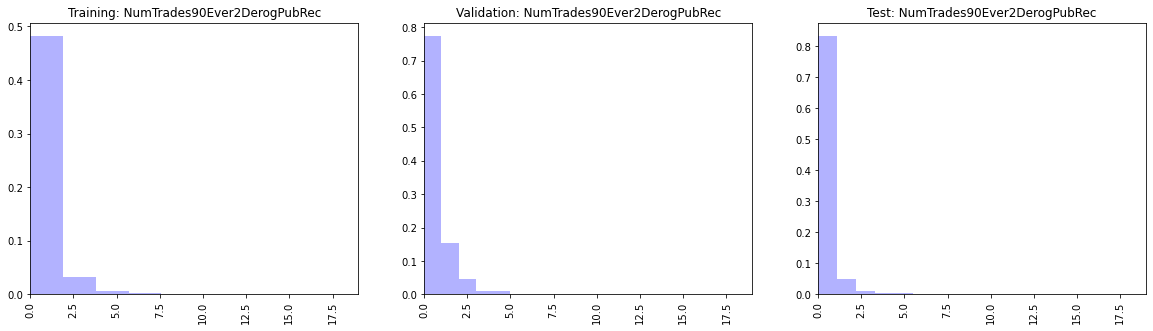

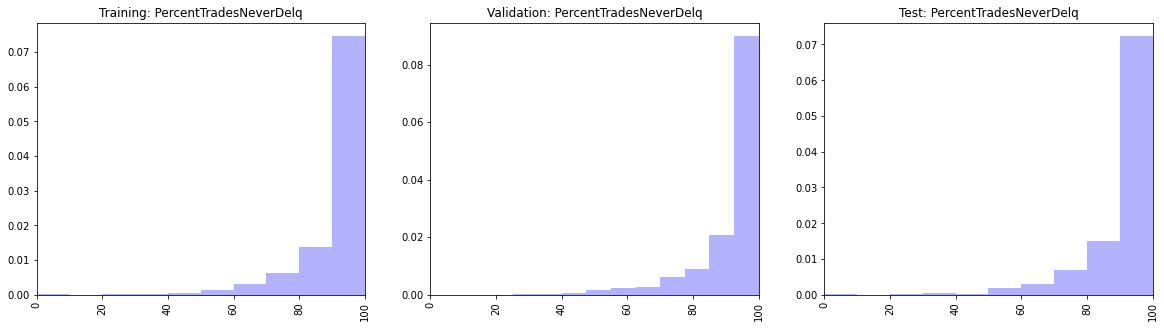

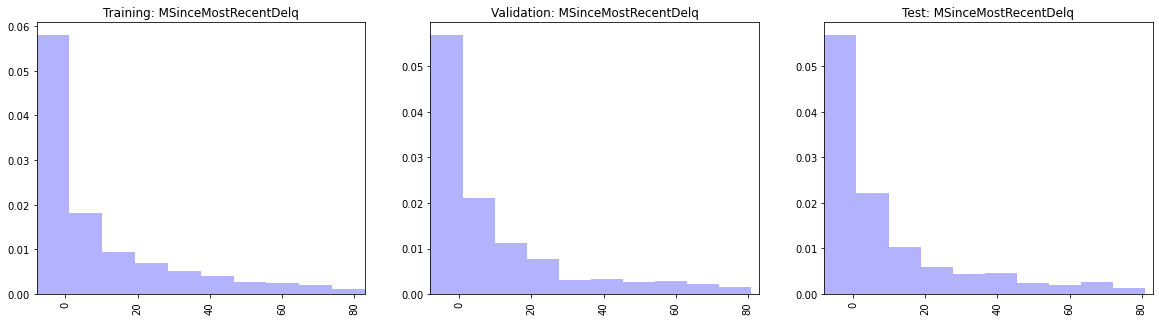

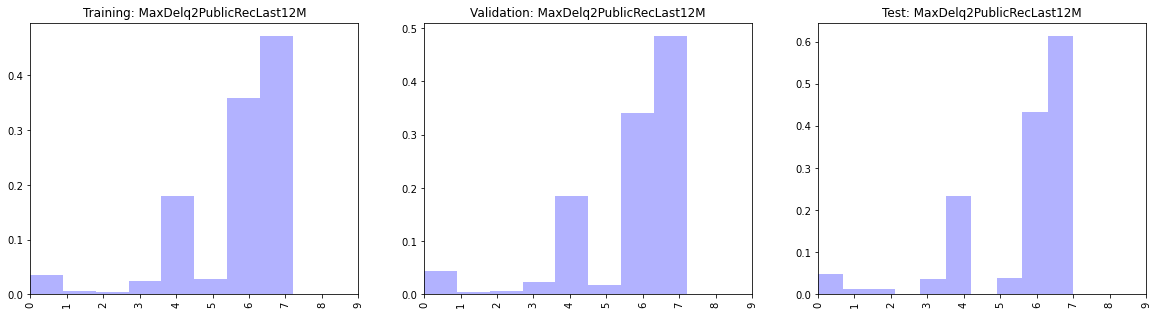

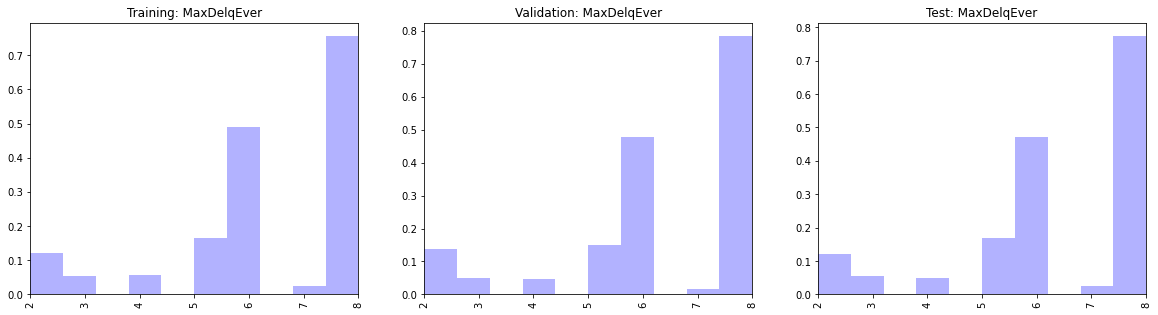

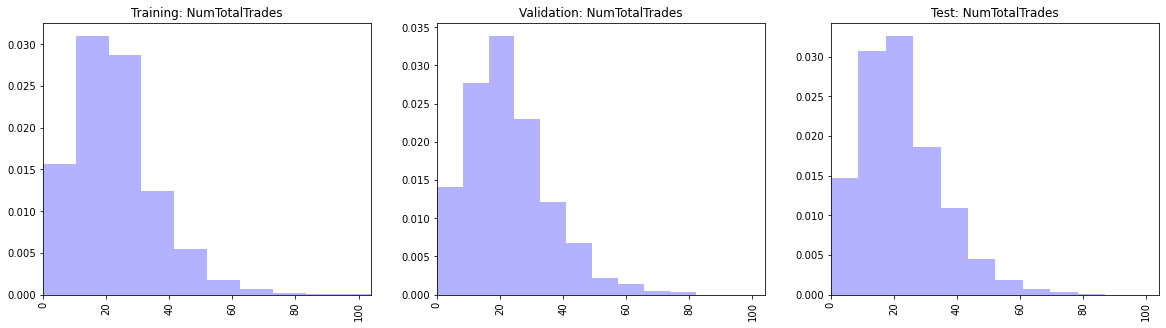

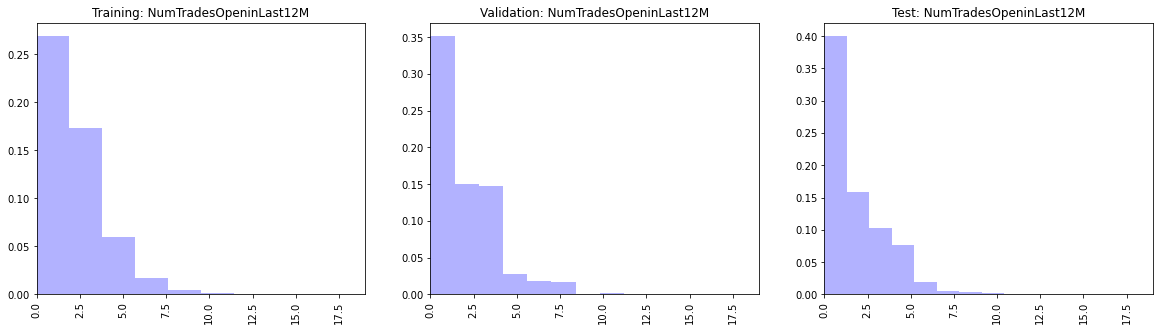

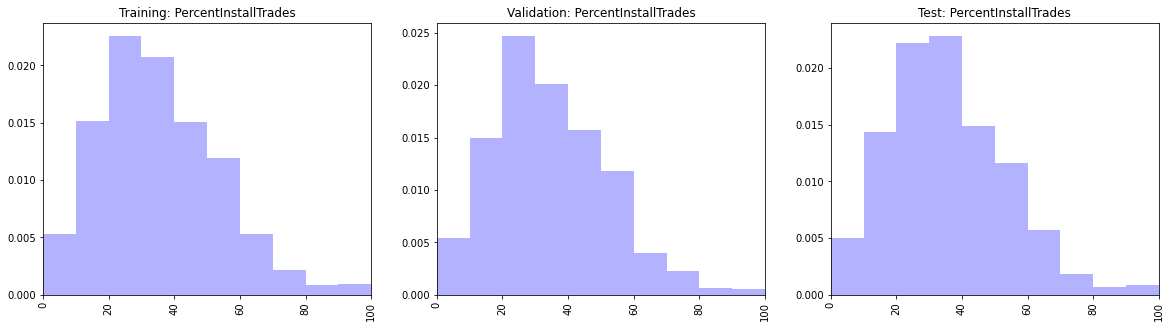

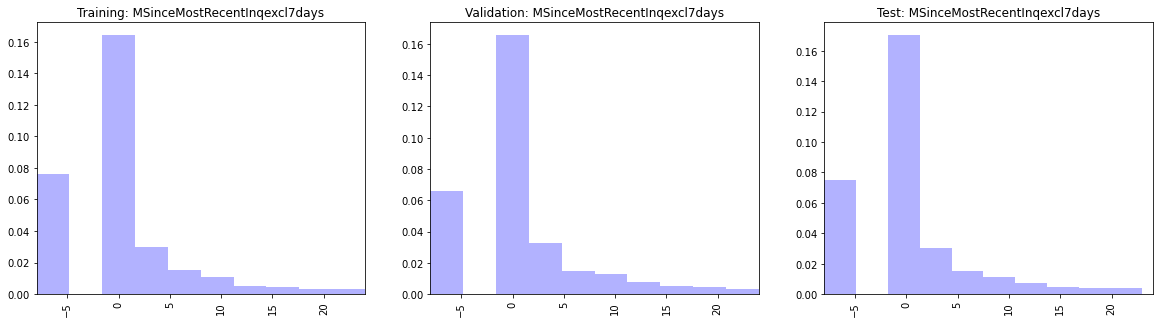

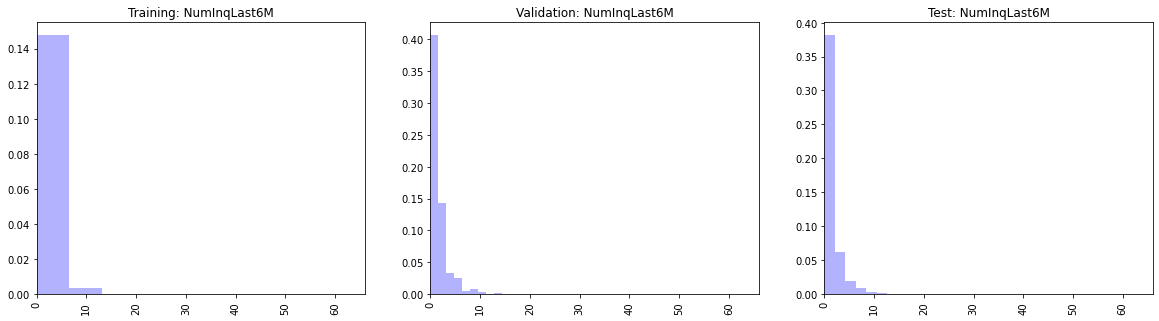

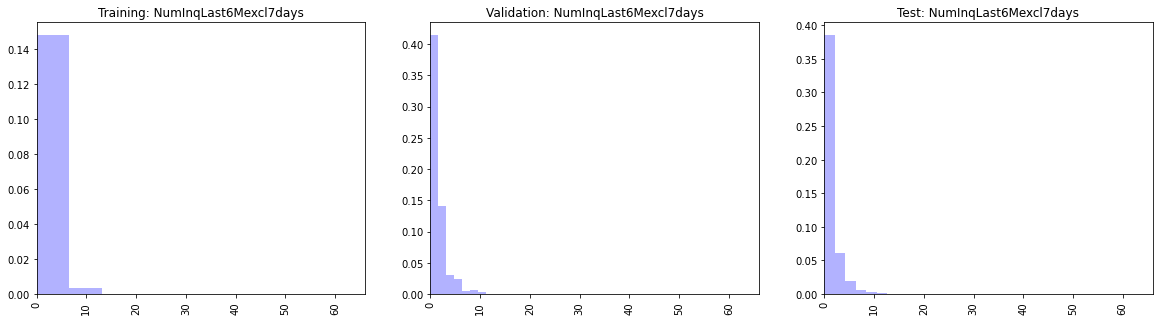

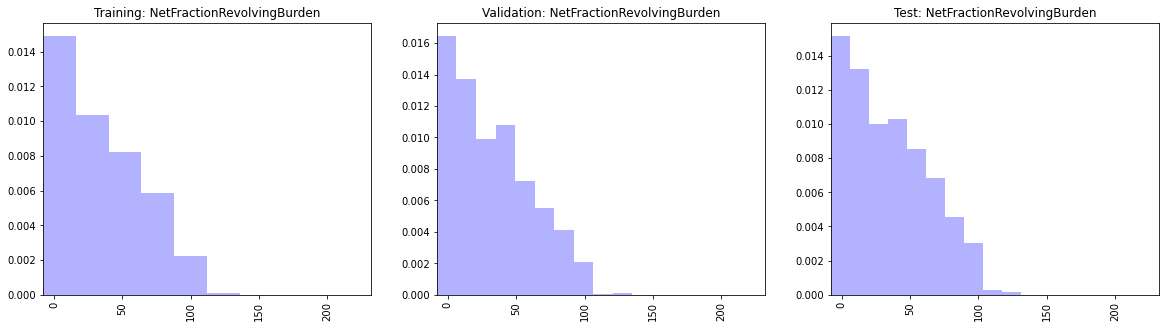

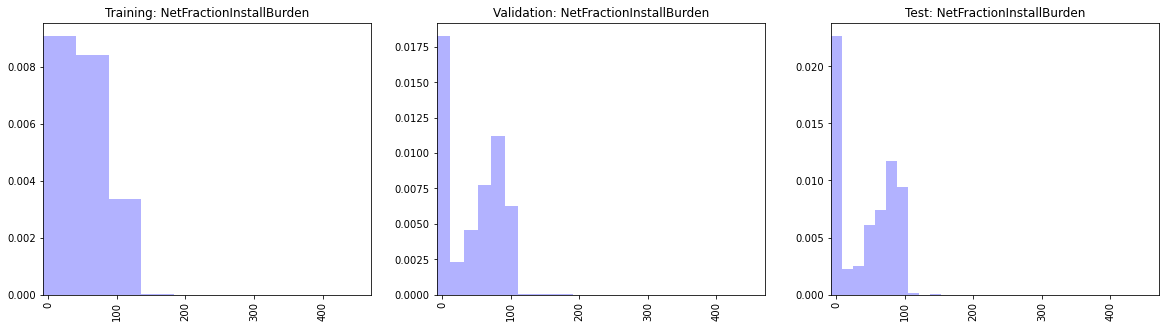

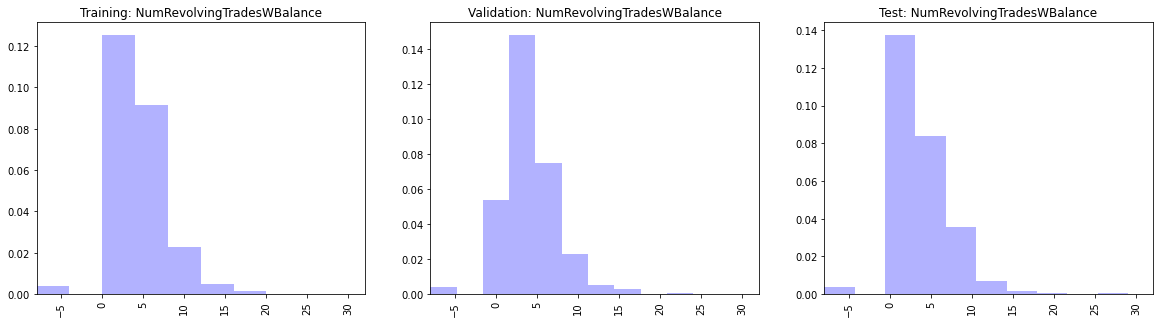

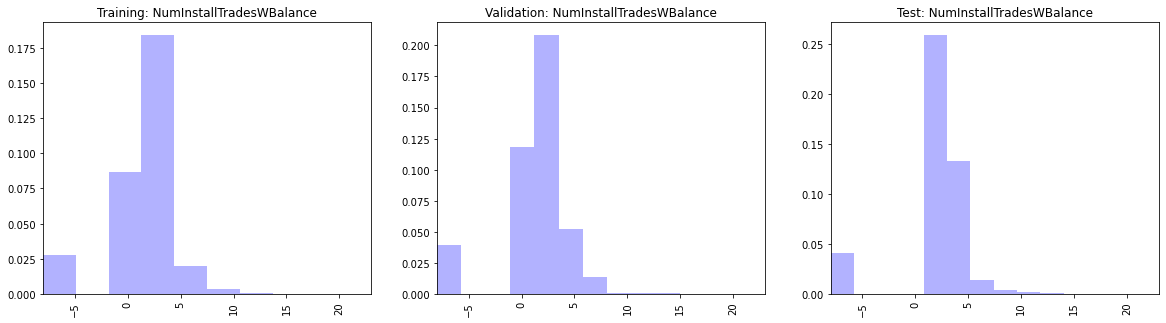

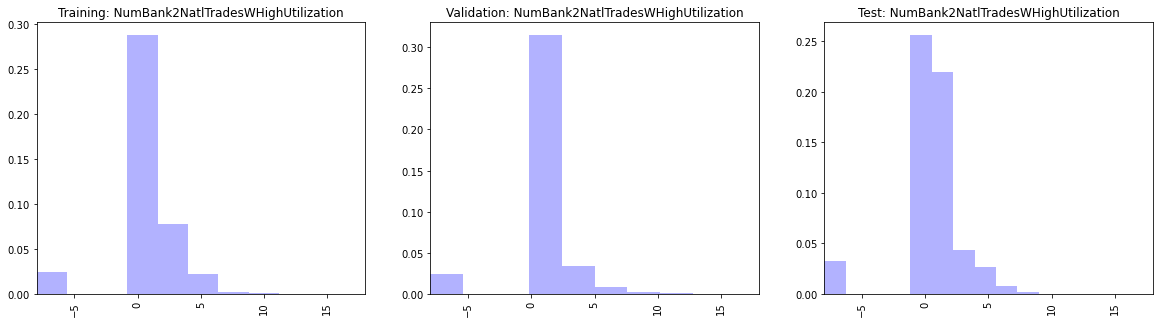

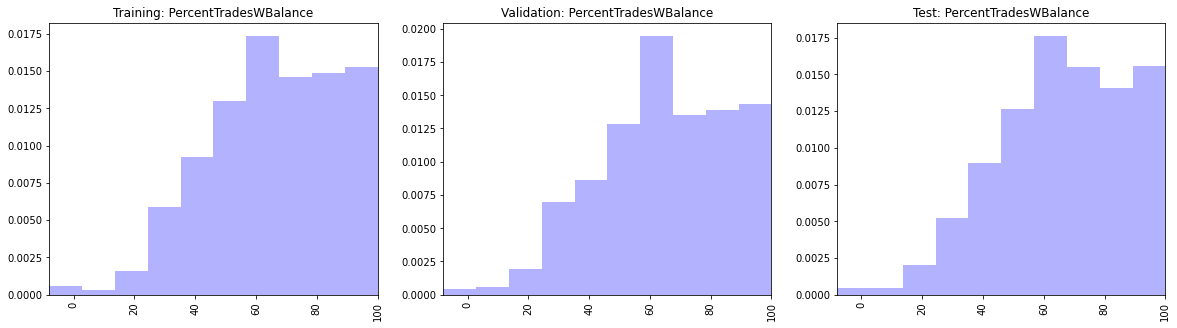

In [163]:
for col in H_train_X.columns:
    
    plt.figure(figsize=(20, 5))

    min_value = float('inf')
    max_value = float('-inf')

    variable_name = col

    # Iterate over the three datasets
    for i, dataset_name, dataset in zip(range(1, 4), ['Training', 'Validation', 'Test'], [H_train_X, H_val_X, H_test_X]):
        plt.subplot(1, 3, i)
        plt.hist(dataset[variable_name], alpha=0.3, color='b', density=True)
        plt.title(f'{dataset_name}: {variable_name}')
        plt.xticks(rotation='vertical')
        
        # Update min and max values for x-axis limits
        min_value = min(min_value, dataset[variable_name].min())
        max_value = max(max_value, dataset[variable_name].max())

    for i in range(1, 4):
        plt.subplot(1, 3, i)
        plt.xlim(min_value, max_value)
    
    plt.show()

### Defining Evaluation Function

### DISCUSSION ABOUT POTENTIAL EVALUATION METRICS AND THEIR TRADE-OFFS, AND WHAT THEIR VALUE IS TO THE PROJECT

In [149]:
def evaluate_classification(y_true, y_predicted):
    """
    The function receives two arrays or pandas Series with the same length, the actual labels and the predicted labels.
    It then prints the sklearn classification_report and plots a confusion matrix as a heatmap using the class ConfusionMatrixDisplay.
    The plot should be readable (e.g. not overlapping labels or too small text)
    :param y_true: array-like; ground truth data class labels
    :param y_predicted: array-like; predicted data class labels
    """
    # TODO: write your code here
    
    cm = confusion_matrix(y_true, y_predicted)
    cmatrix = ConfusionMatrixDisplay(confusion_matrix=cm)
    cmatrix.plot()
    
    print(classification_report(y_true, y_predicted))
    pass

### NO FEATURE ENGINEERING WAS PERFORMED AS THE DATA SET WAS ALREADY CLEAN AND REASONABLY BALANCED SAMPLES

### Baseline Model

### NOT RELEVANT TO THE FINAL PRODUCT, MAYBE AS A COMPARISON TO SHOW THE EFFECTS OF REGULARISATION AND HYPERPARAMETER TUNING

In [173]:
rc = RandomForestClassifier(random_state = 30)
# using the returned decision tree model to initialize a BaggingClassifier
Rbag = rc.fit(H_train_X, H_train_Y)
# fit the bagging classifier model

In [174]:
ypred = Rbag.predict(H_val_X)

In [175]:
Rbag_cv_score = cross_val_score(Rbag, H_val_X, H_val_Y, cv=10, scoring='accuracy')
print(Rbag_cv_score.mean())

0.715439672801636


              precision    recall  f1-score   support

         Bad       0.70      0.77      0.73       820
        Good       0.74      0.67      0.70       807

    accuracy                           0.72      1627
   macro avg       0.72      0.72      0.72      1627
weighted avg       0.72      0.72      0.72      1627



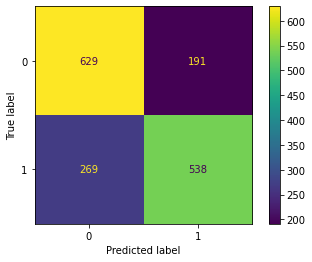

In [176]:
evaluate_classification(H_val_Y, ypred)

In [177]:
importance = Rbag.feature_importances_
importance = importance.astype(float)

feature_importance = pd.DataFrame(
    # creating a new dataframe to store the transformed coefficients of the baseline model
    importance,
    # transforms the coefficient for each feature by multiplying it by its standard deviation
    columns = ['Feature_importance'], index = H_test_X.columns
    # specifying the columns and index for the new data frame
)

feature_importance

,Feature_importance
ExternalRiskEstimate,0.135225
MSinceOldestTradeOpen,0.066276
MSinceMostRecentTradeOpen,0.042448
AverageMInFile,0.076020
NumSatisfactoryTrades,0.052005
NumTrades60Ever2DerogPubRec,0.011839
NumTrades90Ever2DerogPubRec,0.009257
PercentTradesNeverDelq,0.046767
MSinceMostRecentDelq,0.034885
MaxDelq2PublicRecLast12M,0.020267


### Regularisation

### METHODOLOGY AND MEANING FOR REGULARISATION JUSTIFICATION, HOW IT IS PERFORMED AND WHAT THE EXPECTED EFFECT IS

### TALK ABOUT CROSS VALIDATION, AS FURTHER SAMPLING TO REDUCE BIAS IN THE VALIDATION TRAINING AND EVENTUAL EVALUATION TO ENSURE THE MODEL IS APPROPRIATE FOR APPLICATION

In [9]:
RFC = RandomForestClassifier(random_state = 30)

parameter_grid = {
    'n_estimators': np.arange(50, 300, 10),  # Number of trees in the forest
    'max_depth': np.arange(5, 20, 2),  # Maximum depth of each tree
    'min_samples_split': np.arange(2, 10, 1),  # Minimum samples required to split an internal node
    'min_samples_leaf': np.arange(1, 10, 1),  # Minimum number of samples required to be at a leaf node
    'max_features': np.arange(1, 23, 1) # Maximum number of features to consider when making a split
}

# establishing a parameter grid with several combinations of variables and values which will be sequentially 
# iterated through using RandomizedSearchCV to find the optimal setup to maximise the model's performance in accurate 
# predictions on the unseen target variable

In [11]:
random_search = RandomizedSearchCV(
    estimator = RFC,
    param_distributions = parameter_grid,
    n_iter = 100,  # Number of parameter settings that are sampled
    scoring = 'accuracy',  # You can use other scoring metrics
    cv = 5,  # Number of cross-validation folds
    random_state = 30,
    verbose = 2
)
# setting a grid of multiple metrics that will be applied during the RandomizedSearch process to ensure that the 
# best combination are produced for an optimal model

In [12]:
random_search.fit(H_train_X, H_train_Y)
# fitting the gridsearch model with the training data set

print("Best Hyperparameters:", random_search.best_params_)
# producing an output of the optimal hyperparameter values for the chosen parameters

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END max_depth=7, max_features=5, min_samples_leaf=7, min_samples_split=3, n_estimators=250; total time=   1.1s
[CV] END max_depth=7, max_features=5, min_samples_leaf=7, min_samples_split=3, n_estimators=250; total time=   1.2s
[CV] END max_depth=7, max_features=5, min_samples_leaf=7, min_samples_split=3, n_estimators=250; total time=   1.3s
[CV] END max_depth=7, max_features=5, min_samples_leaf=7, min_samples_split=3, n_estimators=250; total time=   1.5s
[CV] END max_depth=7, max_features=5, min_samples_leaf=7, min_samples_split=3, n_estimators=250; total time=   1.2s
[CV] END max_depth=7, max_features=4, min_samples_leaf=7, min_samples_split=2, n_estimators=250; total time=   1.0s
[CV] END max_depth=7, max_features=4, min_samples_leaf=7, min_samples_split=2, n_estimators=250; total time=   1.1s
[CV] END max_depth=7, max_features=4, min_samples_leaf=7, min_samples_split=2, n_estimators=250; total time=   1.2s
[CV] END 

[CV] END max_depth=7, max_features=8, min_samples_leaf=3, min_samples_split=2, n_estimators=190; total time=   1.5s
[CV] END max_depth=7, max_features=8, min_samples_leaf=3, min_samples_split=2, n_estimators=190; total time=   1.5s
[CV] END max_depth=7, max_features=8, min_samples_leaf=3, min_samples_split=2, n_estimators=190; total time=   1.5s
[CV] END max_depth=7, max_features=8, min_samples_leaf=3, min_samples_split=2, n_estimators=190; total time=   1.7s
[CV] END max_depth=7, max_features=8, min_samples_leaf=3, min_samples_split=2, n_estimators=190; total time=   1.7s
[CV] END max_depth=5, max_features=19, min_samples_leaf=3, min_samples_split=3, n_estimators=100; total time=   1.1s
[CV] END max_depth=5, max_features=19, min_samples_leaf=3, min_samples_split=3, n_estimators=100; total time=   1.1s
[CV] END max_depth=5, max_features=19, min_samples_leaf=3, min_samples_split=3, n_estimators=100; total time=   1.1s
[CV] END max_depth=5, max_features=19, min_samples_leaf=3, min_sample

[CV] END max_depth=17, max_features=4, min_samples_leaf=5, min_samples_split=2, n_estimators=120; total time=   0.6s
[CV] END max_depth=17, max_features=4, min_samples_leaf=5, min_samples_split=2, n_estimators=120; total time=   0.6s
[CV] END max_depth=17, max_features=4, min_samples_leaf=5, min_samples_split=2, n_estimators=120; total time=   0.6s
[CV] END max_depth=17, max_features=4, min_samples_leaf=5, min_samples_split=2, n_estimators=120; total time=   0.6s
[CV] END max_depth=17, max_features=4, min_samples_leaf=5, min_samples_split=2, n_estimators=120; total time=   0.6s
[CV] END max_depth=19, max_features=15, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time=   2.6s
[CV] END max_depth=19, max_features=15, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time=   2.2s
[CV] END max_depth=19, max_features=15, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time=   2.3s
[CV] END max_depth=19, max_features=15, min_samples_leaf=4, m

[CV] END max_depth=13, max_features=1, min_samples_leaf=3, min_samples_split=7, n_estimators=180; total time=   0.4s
[CV] END max_depth=13, max_features=1, min_samples_leaf=3, min_samples_split=7, n_estimators=180; total time=   0.4s
[CV] END max_depth=13, max_features=1, min_samples_leaf=3, min_samples_split=7, n_estimators=180; total time=   0.4s
[CV] END max_depth=13, max_features=1, min_samples_leaf=3, min_samples_split=7, n_estimators=180; total time=   0.4s
[CV] END max_depth=13, max_features=1, min_samples_leaf=3, min_samples_split=7, n_estimators=180; total time=   0.4s
[CV] END max_depth=5, max_features=20, min_samples_leaf=8, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END max_depth=5, max_features=20, min_samples_leaf=8, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END max_depth=5, max_features=20, min_samples_leaf=8, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END max_depth=5, max_features=20, min_samples_leaf=8, min_samp

[CV] END max_depth=15, max_features=11, min_samples_leaf=6, min_samples_split=8, n_estimators=220; total time=   2.7s
[CV] END max_depth=15, max_features=11, min_samples_leaf=6, min_samples_split=8, n_estimators=220; total time=   2.4s
[CV] END max_depth=15, max_features=11, min_samples_leaf=6, min_samples_split=8, n_estimators=220; total time=   2.3s
[CV] END max_depth=15, max_features=11, min_samples_leaf=6, min_samples_split=8, n_estimators=220; total time=   2.4s
[CV] END max_depth=13, max_features=4, min_samples_leaf=9, min_samples_split=5, n_estimators=130; total time=   0.5s
[CV] END max_depth=13, max_features=4, min_samples_leaf=9, min_samples_split=5, n_estimators=130; total time=   0.5s
[CV] END max_depth=13, max_features=4, min_samples_leaf=9, min_samples_split=5, n_estimators=130; total time=   0.6s
[CV] END max_depth=13, max_features=4, min_samples_leaf=9, min_samples_split=5, n_estimators=130; total time=   0.5s
[CV] END max_depth=13, max_features=4, min_samples_leaf=9, m

[CV] END max_depth=11, max_features=6, min_samples_leaf=1, min_samples_split=5, n_estimators=250; total time=   2.0s
[CV] END max_depth=11, max_features=6, min_samples_leaf=1, min_samples_split=5, n_estimators=250; total time=   1.8s
[CV] END max_depth=11, max_features=6, min_samples_leaf=1, min_samples_split=5, n_estimators=250; total time=   1.6s
[CV] END max_depth=11, max_features=6, min_samples_leaf=1, min_samples_split=5, n_estimators=250; total time=   1.6s
[CV] END max_depth=9, max_features=19, min_samples_leaf=3, min_samples_split=8, n_estimators=220; total time=   3.1s
[CV] END max_depth=9, max_features=19, min_samples_leaf=3, min_samples_split=8, n_estimators=220; total time=   3.2s
[CV] END max_depth=9, max_features=19, min_samples_leaf=3, min_samples_split=8, n_estimators=220; total time=   3.4s
[CV] END max_depth=9, max_features=19, min_samples_leaf=3, min_samples_split=8, n_estimators=220; total time=   3.4s
[CV] END max_depth=9, max_features=19, min_samples_leaf=3, min_s

[CV] END max_depth=7, max_features=6, min_samples_leaf=7, min_samples_split=6, n_estimators=210; total time=   0.9s
[CV] END max_depth=7, max_features=6, min_samples_leaf=7, min_samples_split=6, n_estimators=210; total time=   0.9s
[CV] END max_depth=7, max_features=6, min_samples_leaf=7, min_samples_split=6, n_estimators=210; total time=   0.9s
[CV] END max_depth=13, max_features=11, min_samples_leaf=1, min_samples_split=4, n_estimators=90; total time=   1.0s
[CV] END max_depth=13, max_features=11, min_samples_leaf=1, min_samples_split=4, n_estimators=90; total time=   1.1s
[CV] END max_depth=13, max_features=11, min_samples_leaf=1, min_samples_split=4, n_estimators=90; total time=   1.2s
[CV] END max_depth=13, max_features=11, min_samples_leaf=1, min_samples_split=4, n_estimators=90; total time=   1.2s
[CV] END max_depth=13, max_features=11, min_samples_leaf=1, min_samples_split=4, n_estimators=90; total time=   1.0s
[CV] END max_depth=11, max_features=15, min_samples_leaf=4, min_sam

[CV] END max_depth=11, max_features=5, min_samples_leaf=3, min_samples_split=3, n_estimators=50; total time=   0.3s
[CV] END max_depth=11, max_features=5, min_samples_leaf=3, min_samples_split=3, n_estimators=50; total time=   0.3s
[CV] END max_depth=11, max_features=12, min_samples_leaf=6, min_samples_split=2, n_estimators=60; total time=   0.7s
[CV] END max_depth=11, max_features=12, min_samples_leaf=6, min_samples_split=2, n_estimators=60; total time=   0.7s
[CV] END max_depth=11, max_features=12, min_samples_leaf=6, min_samples_split=2, n_estimators=60; total time=   0.6s
[CV] END max_depth=11, max_features=12, min_samples_leaf=6, min_samples_split=2, n_estimators=60; total time=   0.6s
[CV] END max_depth=11, max_features=12, min_samples_leaf=6, min_samples_split=2, n_estimators=60; total time=   0.6s
Best Hyperparameters: {'n_estimators': 70, 'min_samples_split': 3, 'min_samples_leaf': 6, 'max_features': 6, 'max_depth': 7}


              precision    recall  f1-score   support

         Bad       0.71      0.76      0.73       820
        Good       0.74      0.68      0.71       807

    accuracy                           0.72      1627
   macro avg       0.72      0.72      0.72      1627
weighted avg       0.72      0.72      0.72      1627



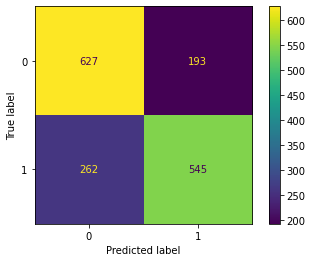

In [178]:
rc = RandomForestClassifier(random_state = 30, 
                            n_estimators = 70,
                            min_samples_split = 3, 
                            min_samples_leaf = 6, 
                            max_features = 6,
                            max_depth = 7)
# using the returned decision tree model to initialize a BaggingClassifier
Rbag = rc.fit(H_train_X, H_train_Y)
# fit the bagging classifier model

ypred = Rbag.predict(H_val_X)

evaluate_classification(H_val_Y, ypred)

### Hyperparameter Tuning

### HYPERPARAMETER TUNED, WHAT THEY DO AND WHY THEY COULD BE HELPFUL (POST PRUNING)

In [15]:
from sklearn.metrics import accuracy_score

In [181]:
alphap = np.logspace(-2, 1, num = 1000)    # establishing a range of potential alpha values to test

# creating empty dictionaries that will have the results of each lambda value appended to then compare and 
# decide on the best regularisation parameter for this particular decision tree regressor model
val_performance, train_performance = {}, {}

for parameter in alphap:
    RFC = RandomForestClassifier(ccp_alpha = parameter, random_state = 30,
                                n_estimators = random_search.best_params_['n_estimators'], 
                                max_depth = random_search.best_params_['max_depth'], 
                                min_samples_leaf = random_search.best_params_['min_samples_leaf'], 
                                min_samples_split = random_search.best_params_['min_samples_split'])
    # initialises and fits a decision tree regressor model onto the training data set
    RFC.fit(H_train_X, H_train_Y)
    
    Typred = RFC.predict(H_train_X)
    accuracy = accuracy_score(H_train_Y, Typred)
    # calculates the evaluation metric scores for the training set performance
    train_performance[parameter] = [accuracy]
    # appends the results into the dictionary under the key of the lambda parameter
    
    Vypred = RFC.predict(H_val_X)
    accuracy = accuracy_score(H_val_Y, Vypred)
    # calculates the evaluation metric scores for the validation set performance
    val_performance[parameter] = [accuracy]
    # appends the results into the dictionary under the key of the lambda parameter

In [182]:
max_key = max(train_performance, key = lambda k: train_performance[k])
print(f"For the alpha value of {max_key}, it has an accuracy of {train_performance[max_key]}")

max_key = max(val_performance, key = lambda k: val_performance[k])
print(f"For the alpha value of {max_key}, it has an accuracy of {val_performance[max_key]}")

For the alpha value of 0.01, it has an accuracy of [0.726158038147139]
For the alpha value of 0.01, it has an accuracy of [0.7074370006146281]


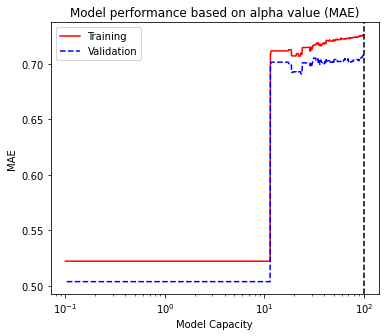

In [183]:
plt.figure(figsize=(20, 5))
# setting the size of the subplots to have appropriate dimensions

# the code to produce these plots to demonstrate the model performance over varying values of lambda
# were originally sourced from the week 5 lab notebooks with some modifications applied

plt.subplot(1, 3, 1)

plt.plot([1.0/alpha_para for alpha_para in alphap], 
         [train_performance[vp][0] for vp in train_performance], 'r-')
# plotting the validation set performance for each value of alpha within the prior logspace

plt.plot([1.0/alpha_para for alpha_para in alphap], 
         [val_performance[vp][0] for vp in val_performance], 'b--')
# plotting the validation set performance for each value of alpha within the prior logspace

plt.axvline(x = (1 / max_key), linestyle='--', color='k')
# plotting a line for the best overall alpha value
plt.title("Model performance based on alpha value (MAE)")
plt.xscale("log")
plt.ylabel('MAE')
plt.xlabel('Model Capacity')
plt.legend(['Training', 'Validation'])


### Evaluation

              precision    recall  f1-score   support

         Bad       0.71      0.76      0.73       820
        Good       0.74      0.68      0.71       807

    accuracy                           0.72      1627
   macro avg       0.72      0.72      0.72      1627
weighted avg       0.72      0.72      0.72      1627



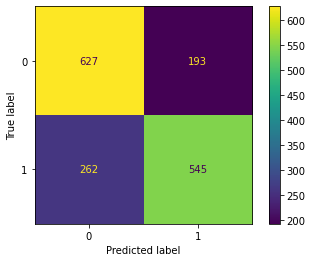

In [192]:
rc = RandomForestClassifier(random_state = 30,
                            n_estimators = 70,
                            min_samples_split = 3, 
                            min_samples_leaf = 6, 
                            max_features = 6,
                            max_depth = 7)
# using the returned decision tree model to initialize a BaggingClassifier
Rbag = rc.fit(H_train_X, H_train_Y)
# fit the bagging classifier model

ypred = Rbag.predict(H_val_X)

evaluate_classification(H_val_Y, ypred)

              precision    recall  f1-score   support

         Bad       0.73      0.78      0.75       857
        Good       0.73      0.68      0.70       771

    accuracy                           0.73      1628
   macro avg       0.73      0.73      0.73      1628
weighted avg       0.73      0.73      0.73      1628



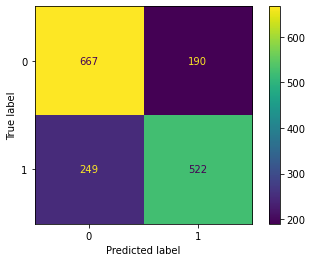

In [191]:
rc = RandomForestClassifier(random_state = 30, 
                            n_estimators = 70,
                            min_samples_split = 3, 
                            min_samples_leaf = 6, 
                            max_features = 6,
                            max_depth = 7)
# using the returned decision tree model to initialize a BaggingClassifier
Rbag = rc.fit(H_train_X, H_train_Y)
# fit the bagging classifier model

ypred = Rbag.predict(H_test_X)

evaluate_classification(H_test_Y, ypred)

## IT CAN BE SEEN THAT ANY ADJUSTMENT TO CCP_ALPHA PERFORMS WORSE SHOWING ANY COST COMPLEXITY PRUNING IS NOT NECESSARY AS THE MODEL ALREADY PERFORMS WELL

### LIME

In [33]:
from lime.lime_tabular import LimeTabularExplainer

In [49]:
# Assuming H_train_X is your DataFrame
H_train_X_np = H_train_X.values

In [39]:
explainer = LimeTabularExplainer(training_data=H_train_X_np, mode="classification")

In [37]:
H_train_X.head()

,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,MaxDelq2PublicRecLast12M,...,PercentInstallTrades,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance
8851,73,115,3,55,40,0,0,100,-7,7,...,58,7,0,0,58,79,4,4,1,82
5801,63,153,3,48,17,0,0,88,4,4,...,47,0,3,3,44,94,3,3,0,50
4090,60,212,2,84,43,0,0,93,11,4,...,23,2,4,4,20,75,10,3,3,52
6403,65,259,39,121,8,1,1,67,5,4,...,11,0,1,1,34,-8,3,-8,-8,60
3551,88,146,16,56,10,0,0,100,-7,7,...,10,17,0,0,16,-8,1,-8,0,17


In [40]:
import random

In [41]:
# Generate a random index
random_index = random.randint(0, len(H_val_X) - 1)

# Select the random test instance from H_val_X
random_test_instance = H_val_X.iloc[random_index]

In [50]:
random_test_instance

ExternalRiskEstimate                   80
MSinceOldestTradeOpen                 242
MSinceMostRecentTradeOpen               8
AverageMInFile                         86
NumSatisfactoryTrades                  16
NumTrades60Ever2DerogPubRec             0
NumTrades90Ever2DerogPubRec             0
PercentTradesNeverDelq                100
MSinceMostRecentDelq                   -7
MaxDelq2PublicRecLast12M                7
MaxDelqEver                             8
NumTotalTrades                         12
NumTradesOpeninLast12M                  1
PercentInstallTrades                   25
MSinceMostRecentInqexcl7days            0
NumInqLast6M                            1
NumInqLast6Mexcl7days                   1
NetFractionRevolvingBurden             37
NetFractionInstallBurden               48
NumRevolvingTradesWBalance              2
NumInstallTradesWBalance                2
NumBank2NatlTradesWHighUtilization      1
PercentTradesWBalance                  67
Name: 3904, dtype: int64

In [199]:
sample_data = random_test_instance.to_dict()

print(sample_data)

{'ExternalRiskEstimate': 80, 'MSinceOldestTradeOpen': 242, 'MSinceMostRecentTradeOpen': 8, 'AverageMInFile': 86, 'NumSatisfactoryTrades': 16, 'NumTrades60Ever2DerogPubRec': 0, 'NumTrades90Ever2DerogPubRec': 0, 'PercentTradesNeverDelq': 100, 'MSinceMostRecentDelq': -7, 'MaxDelq2PublicRecLast12M': 7, 'MaxDelqEver': 8, 'NumTotalTrades': 12, 'NumTradesOpeninLast12M': 1, 'PercentInstallTrades': 25, 'MSinceMostRecentInqexcl7days': 0, 'NumInqLast6M': 1, 'NumInqLast6Mexcl7days': 1, 'NetFractionRevolvingBurden': 37, 'NetFractionInstallBurden': 48, 'NumRevolvingTradesWBalance': 2, 'NumInstallTradesWBalance': 2, 'NumBank2NatlTradesWHighUtilization': 1, 'PercentTradesWBalance': 67}


In [206]:
for col in sample_data:
    print(col, "\n", sample_data[col], type(sample_data[col]))

ExternalRiskEstimate 
 80 <class 'int'>
MSinceOldestTradeOpen 
 242 <class 'int'>
MSinceMostRecentTradeOpen 
 8 <class 'int'>
AverageMInFile 
 86 <class 'int'>
NumSatisfactoryTrades 
 16 <class 'int'>
NumTrades60Ever2DerogPubRec 
 0 <class 'int'>
NumTrades90Ever2DerogPubRec 
 0 <class 'int'>
PercentTradesNeverDelq 
 100 <class 'int'>
MSinceMostRecentDelq 
 -7 <class 'int'>
MaxDelq2PublicRecLast12M 
 7 <class 'int'>
MaxDelqEver 
 8 <class 'int'>
NumTotalTrades 
 12 <class 'int'>
NumTradesOpeninLast12M 
 1 <class 'int'>
PercentInstallTrades 
 25 <class 'int'>
MSinceMostRecentInqexcl7days 
 0 <class 'int'>
NumInqLast6M 
 1 <class 'int'>
NumInqLast6Mexcl7days 
 1 <class 'int'>
NetFractionRevolvingBurden 
 37 <class 'int'>
NetFractionInstallBurden 
 48 <class 'int'>
NumRevolvingTradesWBalance 
 2 <class 'int'>
NumInstallTradesWBalance 
 2 <class 'int'>
NumBank2NatlTradesWHighUtilization 
 1 <class 'int'>
PercentTradesWBalance 
 67 <class 'int'>


In [ ]:
explanation = explainer.explain_instance(random_test_instance, Rbag.predict_proba)

In [55]:
H_train_X.iloc[5]

ExternalRiskEstimate                   73
MSinceOldestTradeOpen                 139
MSinceMostRecentTradeOpen              16
AverageMInFile                         61
NumSatisfactoryTrades                  14
NumTrades60Ever2DerogPubRec             0
NumTrades90Ever2DerogPubRec             0
PercentTradesNeverDelq                100
MSinceMostRecentDelq                   -7
MaxDelq2PublicRecLast12M                7
MaxDelqEver                             8
NumTotalTrades                         14
NumTradesOpeninLast12M                  0
PercentInstallTrades                   14
MSinceMostRecentInqexcl7days            0
NumInqLast6M                            3
NumInqLast6Mexcl7days                   3
NetFractionRevolvingBurden             59
NetFractionInstallBurden               66
NumRevolvingTradesWBalance              6
NumInstallTradesWBalance                1
NumBank2NatlTradesWHighUtilization      2
PercentTradesWBalance                  78
Name: 1509, dtype: int64

In [56]:
explanation = explainer.explain_instance(H_train_X.iloc[5], Rbag.predict_proba)

C:\Users\lxcic\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [57]:
explanation.show_in_notebook()

In [70]:
raw_data = explanation.as_list()
print(raw_data)

[('71.00 < 0 <= 80.00', 0.0925398285274658), ('17 > 54.00', -0.06478890745032431), ('96.00 < 7 <= 100.00', 0.03183341424588893), ('6.00 < 9 <= 7.00', 0.017824494561422613), ('67.00 < 22 <= 82.00', -0.016135415503251174), ('6.00 < 10 <= 8.00', 0.01197527600071453), ('21 > 1.00', -0.00910484299886553), ('5 <= 0.00', 0.007804009827171567), ('2 > 11.00', 0.0071144101236718955), ('16 > 2.00', -0.004999466909679247)]


because LIME models are meant to be simple approximations of the actual model to be more efficient to compute, the number of features shown are reduced to only be the most important to the prediction.

In [58]:
feature_name_to_index = {
    'ExternalRiskEstimate': 0,
    'MSinceOldestTradeOpen': 1,
    'MSinceMostRecentTradeOpen': 2,
    'AverageMInFile': 3,
    'NumSatisfactoryTrades': 4,
    'NumTrades60Ever2DerogPubRec': 5,
    'NumTrades90Ever2DerogPubRec': 6,
    'PercentTradesNeverDelq': 7,
    'MSinceMostRecentDelq': 8,
    'MaxDelq2PublicRecLast12M': 9,
    'MaxDelqEver': 10,
    'NumTotalTrades': 11,
    'NumTradesOpeninLast12M': 12,
    'PercentInstallTrades': 13,
    'MSinceMostRecentInqexcl7days': 14,
    'NumInqLast6M': 15,
    'NumInqLast6Mexcl7days': 16,
    'NetFractionRevolvingBurden': 17,
    'NetFractionInstallBurden': 18,
    'NumRevolvingTradesWBalance': 19,
    'NumInstallTradesWBalance': 20,
    'NumBank2NatlTradesWHighUtilization': 21,
    'PercentTradesWBalance': 22
}

In [62]:
import re

In [80]:
lime_output_mapped = []

for lime_rule in raw_data:
    feature_name = None
    coefficient = lime_rule[1]

    # Use regex to extract the feature index (a single digit)
    match = re.search(r'(^\d\d?| 0[1-9]?|[1-9]\d?) ', lime_rule[0])
    if match:
        feature_index = int(match.group())  # Extract the matched digit
        # Look up the feature name using the index
        for name, index in feature_name_to_index.items():
            if index == feature_index:
                feature_name = name
                break
    
    if feature_name:
        lime_output_mapped.append((feature_name, coefficient))

# Print the mapped LIME output
for feature, coeff in lime_output_mapped:
    print(f"Feature: {feature}, Coefficient: {coeff}")

Feature: ExternalRiskEstimate, Coefficient: 0.0925398285274658
Feature: NetFractionRevolvingBurden, Coefficient: -0.06478890745032431
Feature: PercentTradesNeverDelq, Coefficient: 0.03183341424588893
Feature: MaxDelq2PublicRecLast12M, Coefficient: 0.017824494561422613
Feature: PercentTradesWBalance, Coefficient: -0.016135415503251174
Feature: MaxDelqEver, Coefficient: 0.01197527600071453
Feature: NumBank2NatlTradesWHighUtilization, Coefficient: -0.00910484299886553
Feature: NumTrades60Ever2DerogPubRec, Coefficient: 0.007804009827171567
Feature: MSinceMostRecentTradeOpen, Coefficient: 0.0071144101236718955
Feature: NumInqLast6Mexcl7days, Coefficient: -0.004999466909679247


In [81]:
lime_output_mapped

[('ExternalRiskEstimate', 0.0925398285274658),
 ('NetFractionRevolvingBurden', -0.06478890745032431),
 ('PercentTradesNeverDelq', 0.03183341424588893),
 ('MaxDelq2PublicRecLast12M', 0.017824494561422613),
 ('PercentTradesWBalance', -0.016135415503251174),
 ('MaxDelqEver', 0.01197527600071453),
 ('NumBank2NatlTradesWHighUtilization', -0.00910484299886553),
 ('NumTrades60Ever2DerogPubRec', 0.007804009827171567),
 ('MSinceMostRecentTradeOpen', 0.0071144101236718955),
 ('NumInqLast6Mexcl7days', -0.004999466909679247)]

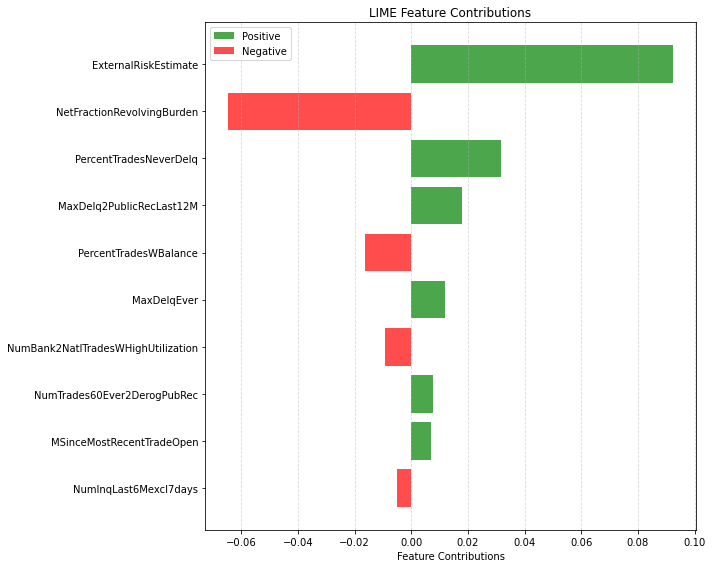

In [95]:
# Extract feature names and values
feature_names, values = zip(*lime_output_mapped)

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Create horizontal bars for positive and negative values
ax.barh(feature_names, [max(0, val) for val in values], color='green', label='Positive', alpha=0.7)
ax.barh(feature_names, [min(0, val) for val in values], color='red', label='Negative', alpha=0.7)

# Add labels and legend
ax.set_xlabel('Feature Contribution')
ax.set_title('LIME Feature Contributions')
ax.legend()

ax.xaxis.grid(True, linestyle='--', alpha=0.5)

# Invert the y-axis to display the most important features at the top
ax.invert_yaxis()

# Show the plot
plt.tight_layout()
plt.show()

In [98]:
explanation.predict_proba

array([0.62889454, 0.37110546])

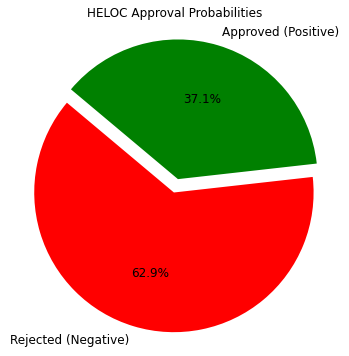

In [111]:
labels = ['Rejected (Negative)', 'Approved (Positive)']

# Colors for the pie chart
colors = ['red', 'green']

# Explode a slice to emphasize it
explode = (0.1, 0)

plt.figure(figsize=(6, 6))

# Create a pie chart
plt.pie(explanation.predict_proba, labels=labels, colors=colors, explode=explode, autopct='%1.1f%%', textprops={'fontsize': 12}, startangle=140)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')

# Title
plt.title('HELOC Approval Probabilities')

# Show the pie chart
plt.show()

In [195]:
H_test_X.to_csv('H_test.csv', index=False)

### Exporting Model

In [47]:
import pickle

In [193]:
# Save the model
with open('model.pkl', 'wb') as file:
    pickle.dump(Rbag, file)